In [264]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [285]:
W = 1/2

def pulse(t):
    if 0.15 < t < 0.15 + W:
        return 1
    elif 0.65 < t < 0.65 + W:
        return -1
    else:
        return 0

def esp(t):
    if 0.15 < t < 0.15 + W:
        return pow(2.71,-(t-0.15)*5)
    elif 0.65 < t < 0.65 + W:
        return -pow(2.71,-(t-0.65)*5)
    else:
        return 0
    
pulse = np.vectorize(pulse,otypes=[np.float64])
esp = np.vectorize(esp,otypes=[np.float64])

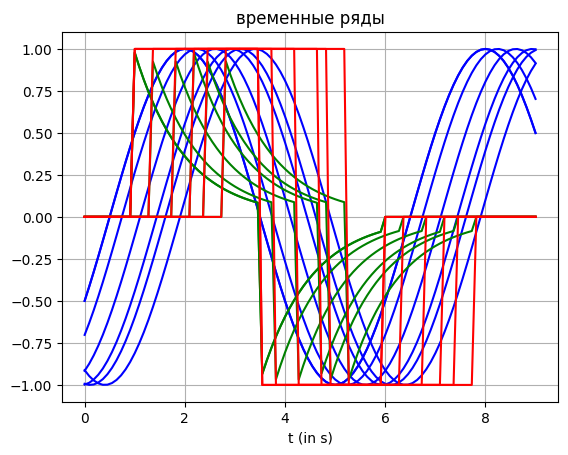

In [286]:
# индекс и отсчет времени в секундах
time_index = np.linspace(0, 9, 100)

tseries_list = {'Time': time_index}
d = np.random.random(size=10)


N = 7 #количество образцов в каждом типе сигналов


# гармонические колебания
f0 = 0.2

for i in range(N):
    tseries_list["Tc"+str(i)]= esp((time_index + 2*d[i] - 2)/5)

# модифицированный синус 
for i in range(N):
    tseries_list["Ts"+str(i)]= np.sin((np.pi*time_index+ 5*d[i] - 6)/3)

# пульс сигнал
for i in range(N):
    tseries_list["Tp"+str(i)]= pulse((time_index + 2*d[i] - 2)/5)


# отрисовка всех сигналов
for i in range(N):
    plt.plot(time_index, tseries_list["Ts"+str(i)], '-b')
for i in range(N):
    plt.plot(time_index, tseries_list["Tc"+str(i)], '-g')
for i in range(N):
    plt.plot(time_index, tseries_list["Tp"+str(i)], '-r')
            
plt.title(r'временные ряды')
plt.xlabel(r't (in s)')
plt.grid()

In [287]:
def distance_matrix(x, y, q) -> np.array:
    """
    Функция  рассчета  матрицы  расстояний между точками двух рядов 
    """
    mdist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            mdist[i,j] = np.abs((x[j]-y[i]))**q
    return mdist

In [288]:
# Посчитаем DTW для двух временных рядов
# Сначала напишем функцию, которая это все вычисляет


def DTW(x, x_s, q=1, isDTW=True):
    '''
        x: первый ряд
        x_s : второй ряд
        q : степень для вычисления базового расстояния
    '''
    N = len(x) # Считаем, что ряды равной длины. Но это не всегда так, перепишите функцию для 
               # вычисления расстояния между рядами, длины которых не равны
    

    #Дополнение, чтобы работало с рядами разных длин
    if len(x) != len(x_s):
        if len(x) < len(x_s):
            x = interp1d(np.linspace(0,1,len(x)),x,kind="nearest")(np.linspace(0,1,len(x_s)))
        else:
            x_s = interp1d(np.linspace(0,1,len(x_s)),x_s,kind="nearest")(np.linspace(0,1,len(x)))

    # Строим матрицу согласно реккурентной формуле, полученной выше. Матрица в нашем случае будет размерности 

    dist = distance_matrix(x,x_s,q=2)
    
    R = [[0] * (N+1) for i in range(N+1)]
   
    for i in range(1,N): 
        R[i][0] = dist[i,0] + R[i-1][0] 
        R[0][i] = dist[0,i] + R[0][i-1]
    
    # проверяем, что записалось
    #print("Начинаем заполнять матрицу R")
    #for i in range(N+1): 
    #    print(R[i])

    k = 0
    if isDTW:
        k = 1
    
    # начинаем расчет по реккурентной формуле
  
    for i in range(1,N+1): 
        for j in range(1,N+1):
            R[i][j] = dist[i-1,j-1] + k*np.min([R[i-1][j-1], R[i][j-1], R[i-1][j]]) 

    # проверяем, что записалось
    # print("\nпосле заполнения матрицы R")
    #for i in range(N+1): 
    #    print(R[i])

    # ищем минимальный путь. Начинаем от нижнего правого угла.
    pth = []   # лист с кортежами индексов пути
    i = N
    j = N
    while i >= 0 and j >= 0:
        pth.append((i,j))
        if R[i][j-1] <= R[i-1][j-1] and R[i][j-1] <= R[i-1][j]:
            I = i
            J = j-1                
        
        if R[i-1][j] <= R[i-1][j-1] and R[i-1][j] <= R[i][j-1]:
            I = i - 1
            J = j 

        if R[i-1][j-1] <= R[i][j-1] and R[i-1][j-1] <= R[i-1][j]:
            I = i - 1
            J = j - 1
        
        i = I
        j = J
    
            
    #print("\nПуть:")
    #print(pth)

    #Считаем расстояние между двумя рядами
    s = 0
    for l in pth:
        s += R[l[0]][l[1]]
    s = s/len(pth) 

    return s, pth, R

In [289]:
# Посчитаем DTW для двух временных рядов

#для простоты выделяем ряды, которые будем сравнивать
x = np.abs(tseries_list["Ts1"])
x_s = np.abs(tseries_list["Ts6"])
x_p = np.abs(tseries_list["Tp2"])
s1 = DTW(x,x_s,q=2)
s2 = DTW(x,x_p,q=2)

print (f"DTW\nTs1 и Ts3 = {s1[0]}     Ts1 и Tp1 = {s2[0]}")

s11 = DTW(x,x_s,q=2, isDTW=False)
s21 = DTW(x,x_p,q=2, isDTW=False)

print (f"Dec\nTs1 и Ts3 = {s11[0]}     Ts1 и Tp1 = {s21[0]}")

DTW
Ts1 и Ts3 = 0.04514299773943514     Ts1 и Tp1 = 7.635021737756149
Dec
Ts1 и Ts3 = 0.0013089362438469304     Ts1 и Tp1 = 0.2120818616833652


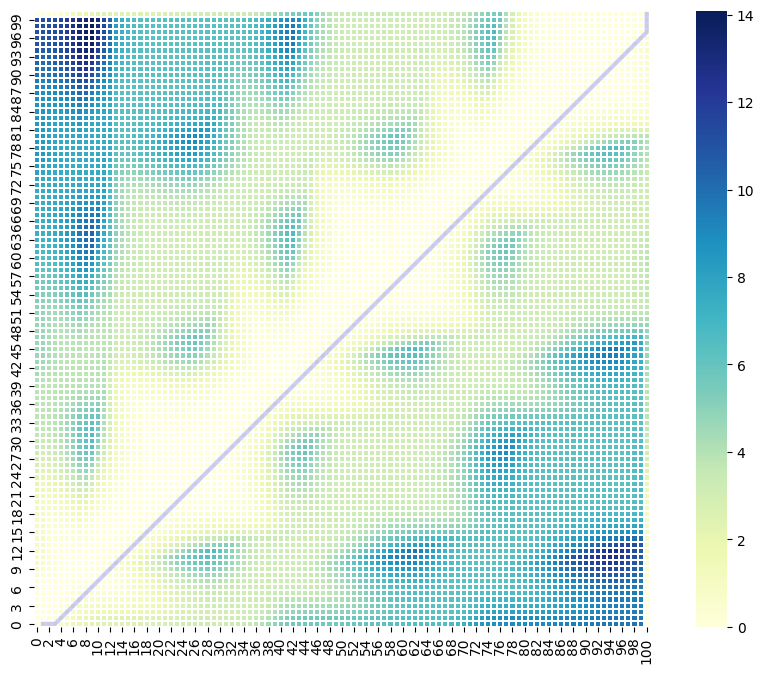

In [290]:
import seaborn as sbn
# Отрисуем матрицы весов расстояний Ts1 и Ts3 

cost_matrix = s1[2]
warp_path = s1[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

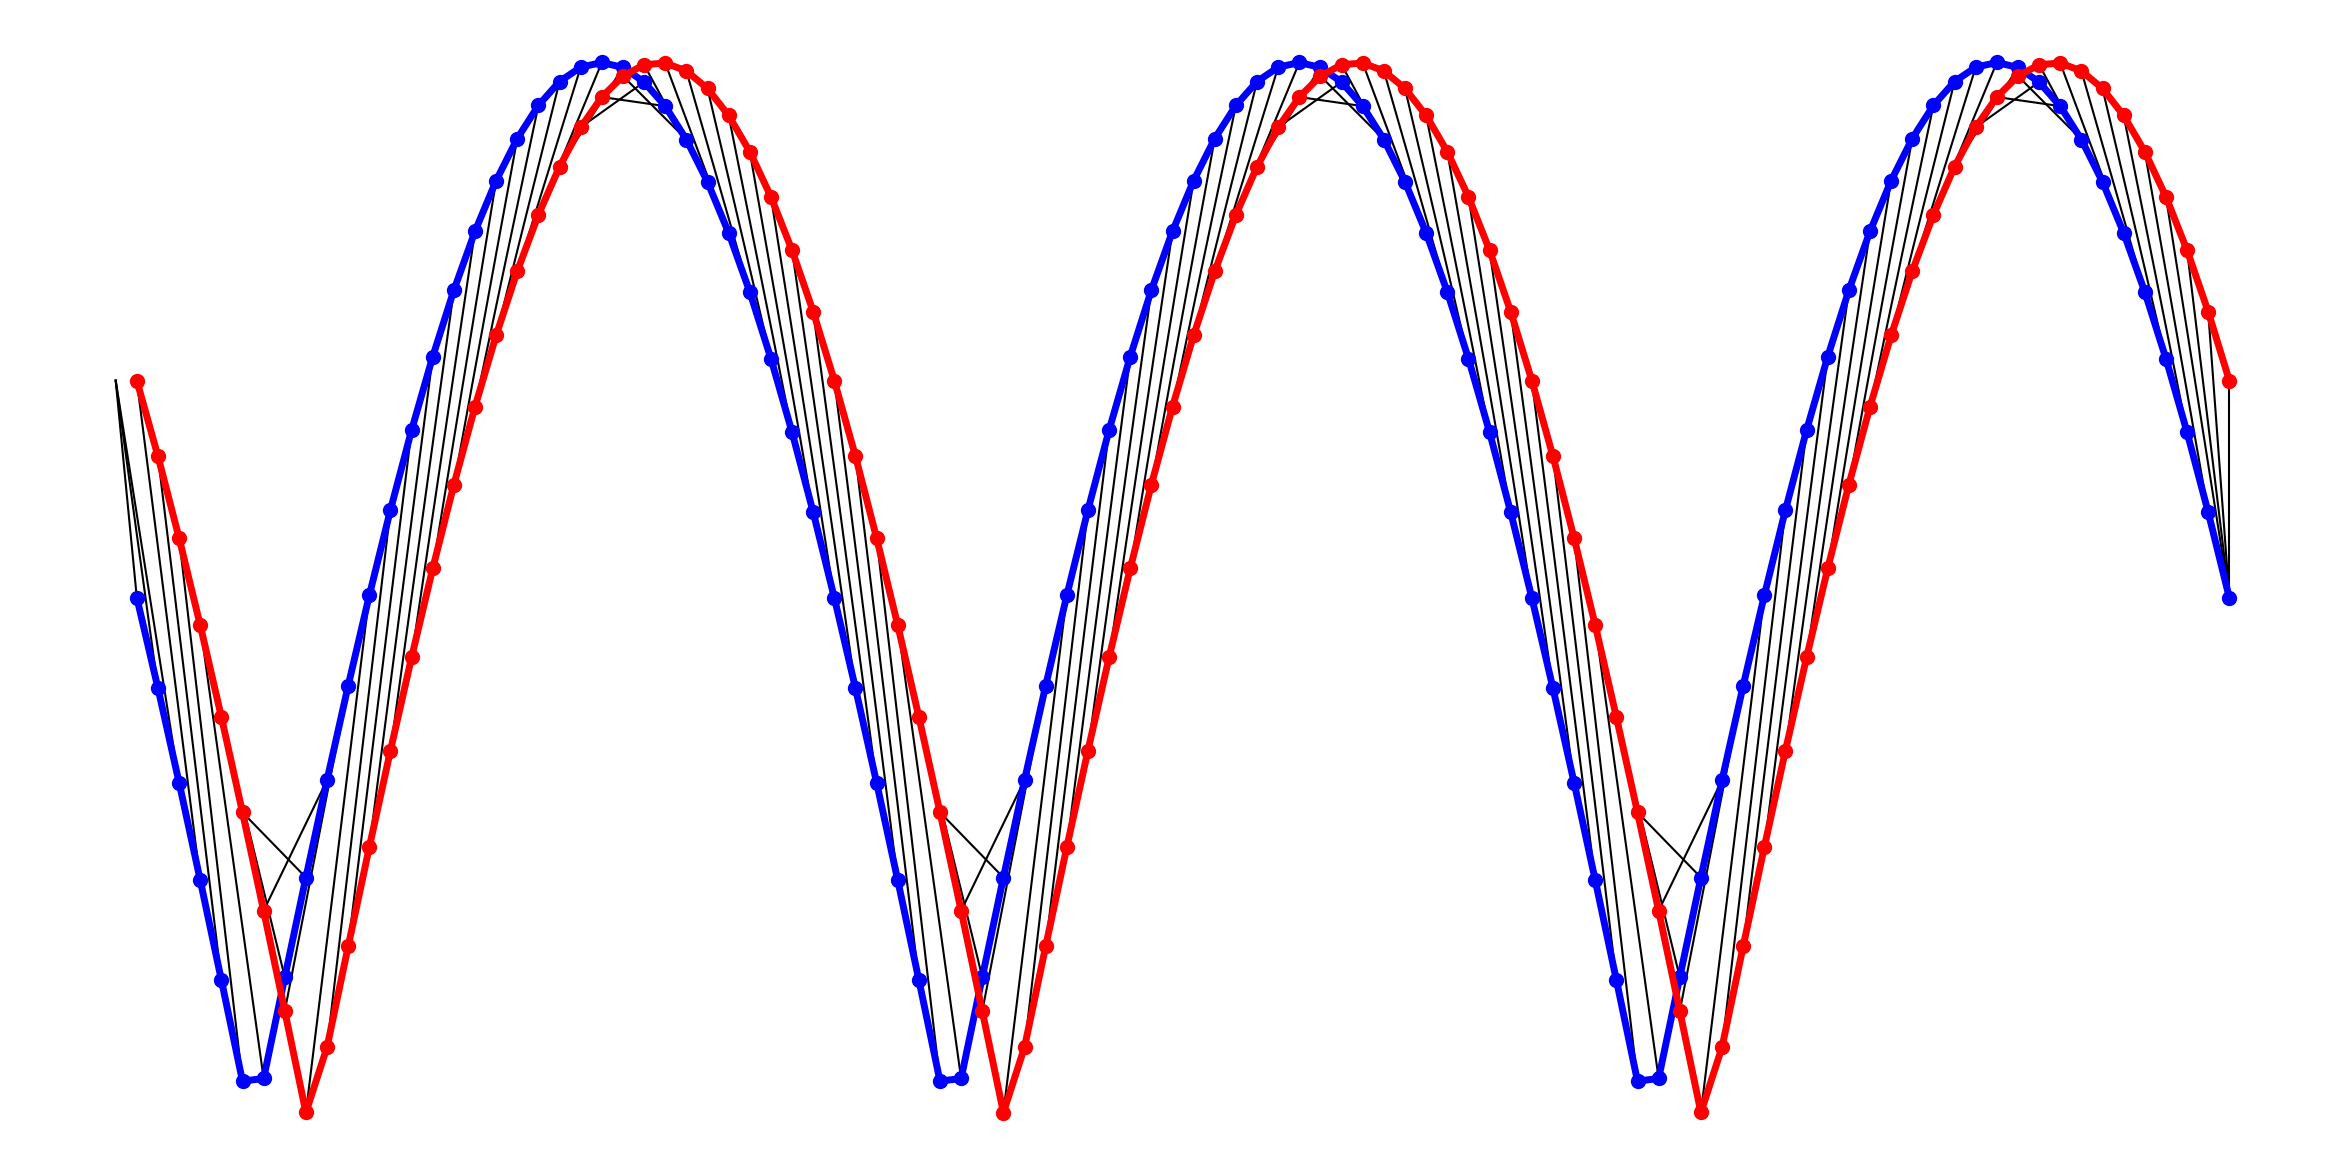

In [291]:
fig, ax = plt.subplots(figsize=(30, 15))


warp_path = s1[1]
x1 = x
x2 = x_s

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

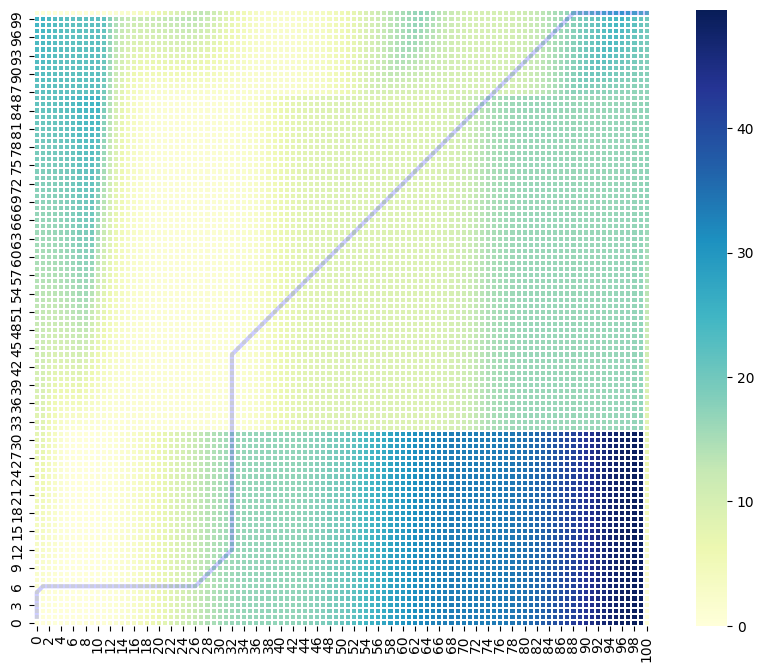

In [292]:
# Отрисуем матрицы весов расстояний Ts1 и Tp1

cost_matrix = s2[2]
warp_path = s2[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

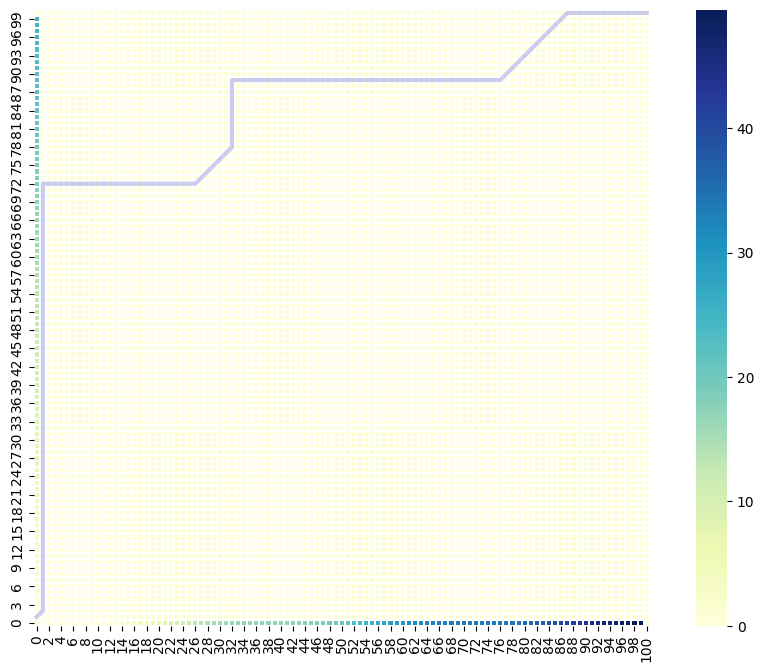

In [293]:
# Отрисуем матрицы весов расстояний Ts1 и Tp1 без DTW

cost_matrix = s21[2]
warp_path = s21[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

In [294]:
from dtaidistance import dtw

x = np.abs(tseries_list["Ts1"])
x_s = np.abs(tseries_list["Ts6"])


distance, paths = dtw.warping_paths(x, x_s)
print(distance)
print(paths)

0.4031487870118781
[[0.                inf        inf ...        inf        inf        inf]
 [       inf 0.20334454 0.24269998 ... 3.34485124 3.35555753 3.36171315]
 [       inf 0.35253898 0.29748155 ... 3.35414287 3.3633717  3.36789267]
 ...
 [       inf 3.12327601 3.06113513 ... 0.37912188 0.34335415 0.32557015]
 [       inf 3.12570585 3.0615831  ... 0.45153938 0.39131731 0.3481091 ]
 [       inf 3.13231322 3.06444862 ... 0.55656378 0.47420011 0.40314879]]


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

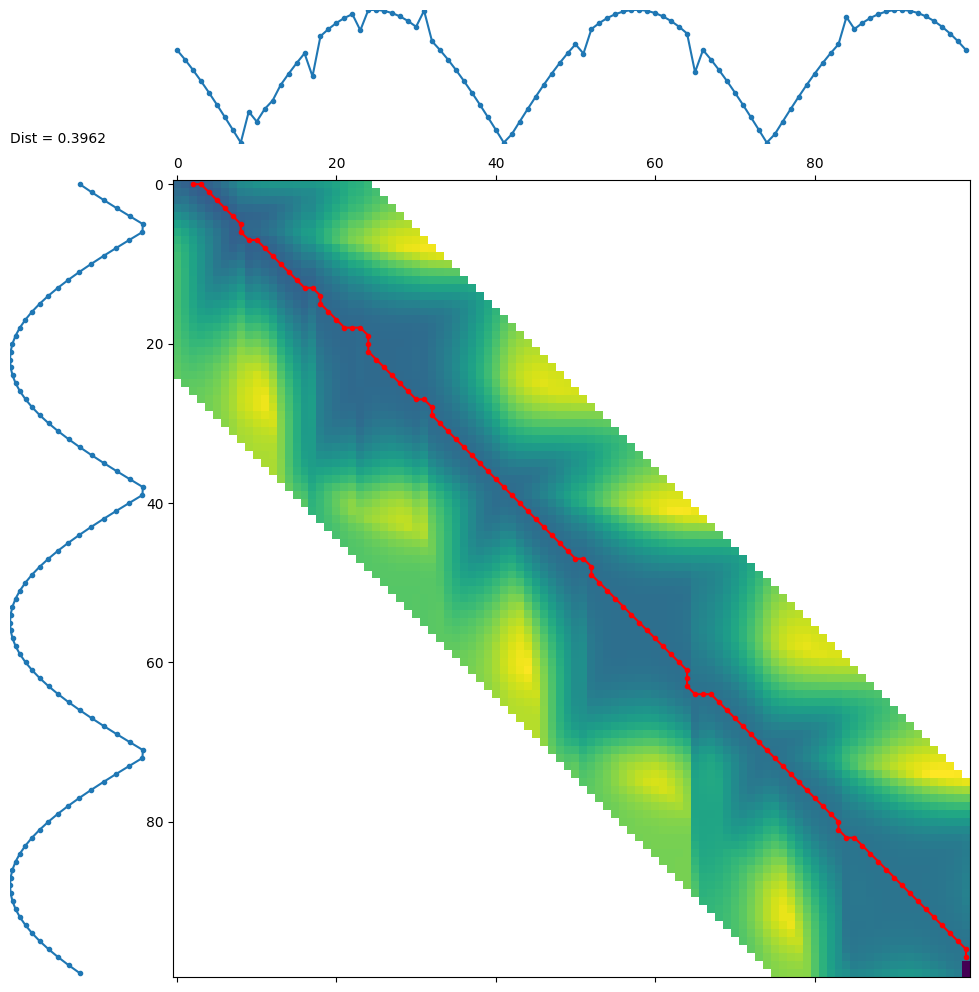

In [295]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
xw = np.arange(0, 20, .5)
s1 = x
s2 = x_s
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

In [296]:
x = np.abs(tseries_list["Ts1"])
x_p = np.abs(tseries_list["Tp2"])


distance, paths = dtw.warping_paths(x, x_p)
print(distance)
print(paths)

4.528700696281186
[[0.                inf        inf ...        inf        inf        inf]
 [       inf 0.49891838 0.70557714 ... 4.95106999 4.97614446 5.0010932 ]
 [       inf 0.64849568 0.64849568 ... 4.85649923 4.87413703 4.89171125]
 ...
 [       inf 7.01175537 7.01175537 ... 4.68501864 4.73043409 4.77541764]
 [       inf 7.03562364 7.03562364 ... 4.57535531 4.61185027 4.64805869]
 [       inf 7.0532914  7.0532914  ... 4.47339814 4.50113435 4.5287007 ]]


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

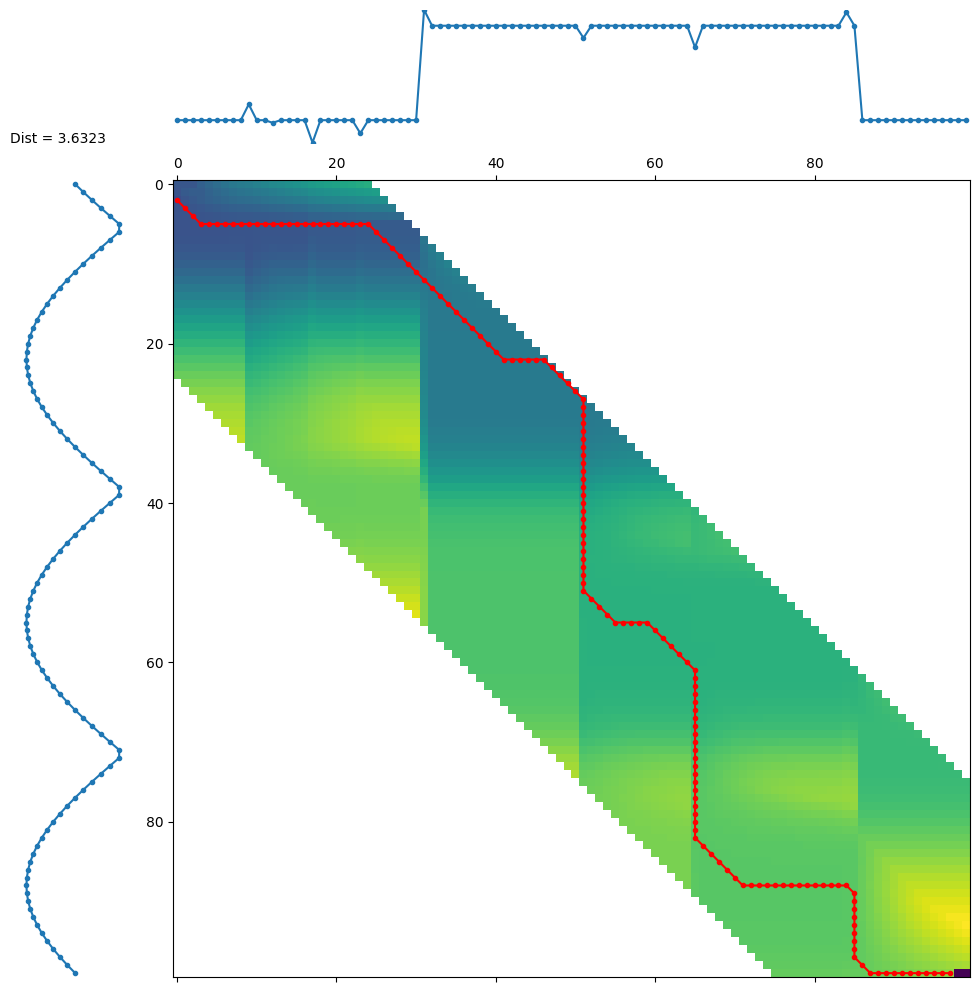

In [297]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
xw = np.arange(0, 20, .5)
s1 = x
s2 = x_p
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

In [298]:
# переделываем датасет так, чтобы с ним можно было бы работать

x = []  #значения
Y = []  # целевая переменная

for v in tseries_list:
    if v!= 'Time':
        x.append(tseries_list[v])
        c = v[:-1]
        if c == "Ts":
            Y.append(0)
        elif c == "Tc":
            Y.append(1)
        else: Y.append(2)


arr = np.arange(len(Y))
np.random.shuffle(arr)


print(Y)

X_train = []
X_test = []
y_train = []
y_test = []

for i in arr[:-5]:
    X_train.append(x[i])
    y_train.append(Y[i])

for i in arr[len(X_train):]:
    X_test.append(x[i])
    y_test.append(Y[i])

[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2]


In [299]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='minkowski')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[2].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {y_test[2]}")

Accuracy 0.6
Вектор вероятности принадлежности к классам [[0. 1. 0.]]
Истинный класс для предсказаний 2


In [300]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[2].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {y_test[2]}")

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0. 0. 1.]]
Истинный класс для предсказаний 2


In [301]:
import numpy as np 
from pyts.classification import TimeSeriesForest
import matplotlib.pyplot as plt

 
clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)


print(f"Accuracy {clf.score(X_test, y_test)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[2].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {y_test[2]}")


Accuracy 0.8
Вектор вероятности принадлежности к классам [[0.23 0.05 0.72]]
Истинный класс для предсказаний 2
